# Naive Bayes Classifier and addressing curse of dimensionality through various Feature Selection methods

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from scipy import stats
from sklearn.preprocessing import StandardScaler
#from scipy.stats import yeojohnson, skew
from sklearn.preprocessing import PowerTransformer
from sklearn.manifold import TSNE
from imblearn.combine import SMOTEENN

import warnings; warnings.simplefilter('ignore')

# 0. Reading The Dataset

In [2]:
# Loading and reading the glass dataset
glass_df = pd.read_csv('/content/glass.csv')
glass_df.head(10)

idno       RI     Na    Mg    Al     Si     K    Ca   Ba    Fe  type
0     1  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.00     1
1     2  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.00     1
2     3  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.00     1
3     4  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.00     1
4     5  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.00     1
5     6  1.51596  12.79  3.61  1.62  72.97  0.64  8.07  0.0  0.26     1
6     7  1.51743  13.30  3.60  1.14  73.09  0.58  8.17  0.0  0.00     1
7     8  1.51756  13.15  3.61  1.05  73.24  0.57  8.24  0.0  0.00     1
8     9  1.51918  14.04  3.58  1.37  72.08  0.56  8.30  0.0  0.00     1
9    10  1.51755  13.00  3.60  1.36  72.99  0.57  8.40  0.0  0.11     1

In [3]:
# Dropping idno
glass_df = glass_df.drop(columns = 'idno')

The features for classifying the target variable (glass) `type` are: Refractive Index (RI), Sodium (Na), Magnesium (Mg), Aluminum (Al), Silicon (Si), Potassium (K), Calcium (Ca), Barium (Ba), Iron (Fe). Each record has a respective id number (id no).

# 1. Data Exploration

In [4]:
# Checking the Shape
glass_df.shape

(214, 10)

There are 10 columns (9 features, 1 class column) and 214 rows (data) in total.

In [5]:
# Checking the information
glass_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


In [6]:
# Checking for Null and NaN values:
glass_df.isnull().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
type    0
dtype: int64

There are no NaN or Null values in each feature and on the target variable. Every feature is represented in a float while the type is an integer.

In [7]:
''' describing the data with mean as a measure of central tendency,
    calculating Q1 - Q3 for each feature as a measure of relative location,
    standard deviation as a measure of relative dispersion,
    and the min/max values for each column.
'''
glass_df.describe()

RI          Na          Mg          Al          Si           K  \
count  214.000000  214.000000  214.000000  214.000000  214.000000  214.000000   
mean     1.518365   13.407850    2.684533    1.444907   72.650935    0.497056   
std      0.003037    0.816604    1.442408    0.499270    0.774546    0.652192   
min      1.511150   10.730000    0.000000    0.290000   69.810000    0.000000   
25%      1.516522   12.907500    2.115000    1.190000   72.280000    0.122500   
50%      1.517680   13.300000    3.480000    1.360000   72.790000    0.555000   
75%      1.519157   13.825000    3.600000    1.630000   73.087500    0.610000   
max      1.533930   17.380000    4.490000    3.500000   75.410000    6.210000   

               Ca          Ba          Fe        type  
count  214.000000  214.000000  214.000000  214.000000  
mean     8.956963    0.175047    0.057009    2.780374  
std      1.423153    0.497219    0.097439    2.103739  
min      5.430000    0.000000    0.000000    1.000000  
25%      8.240000    0.000000    0.000000    1.000000  
50%      8.600000    0.000000    0.000000    2.000000  
75%      9.172500    0.000000    0.100000    3.000000  
max     16.190000    3.150000    0.510000    7.000000

The data is described above with the mean as a measure of central tendency, calculating Q1 - Q3 for each feature as a measure of relative location, standard deviation as a measure of relative dispersion,and the min/max values for each column.

From the mean values alone, we can infer that glass generally has a lot of Silicon, Sodium, and Calcium apart from the other chemical content. The Refraction Index (RI) is used to measure how efficient light refraction is on the material (ratio between speed of light in vacuum and speed of light through said material). Essentially, the lower the number; the faster light travels through the medium,the less the light is bent, and the less efficient refraction is. To put things into perspective, the RI of [water](https://refractiveindex.info/?shelf=main&book=H2O&page=Hale) is 1.333, [diamond](https://refractiveindex.info/?shelf=3d&book=crystals&page=diamond) has 2.42, and [glass](https://refractiveindex.info/?shelf=3d&book=glass&page=BK7) generally has 1.52.

In [8]:
# Distribution exploration for the class
glass_df['type'].value_counts()

type
2    76
1    70
7    29
3    17
5    13
6     9
Name: count, dtype: int64

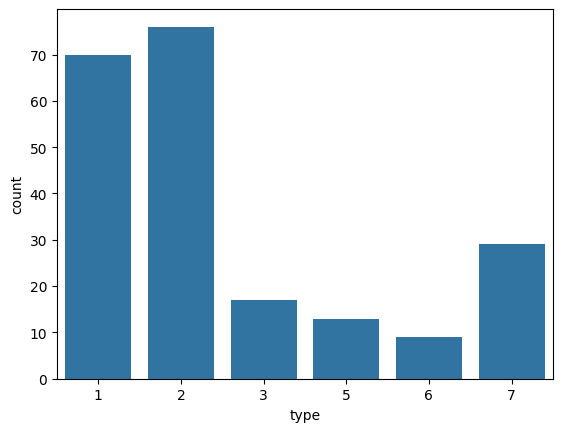

In [9]:
sns.countplot(x = 'type', data = glass_df)
plt.show()

The following shows the classes of glass (1, 2, 3, 5, 6, 7). The count of each class is presented in descending order, showing incredible class imbalance. This raises the concern of the model possibly classifying the frequent class while misclassifying the ones with minor counts.

In [10]:
# Assigning features on `feature` and target variable on `target`
features = glass_df.drop(columns = ['type'])
target = glass_df['type']

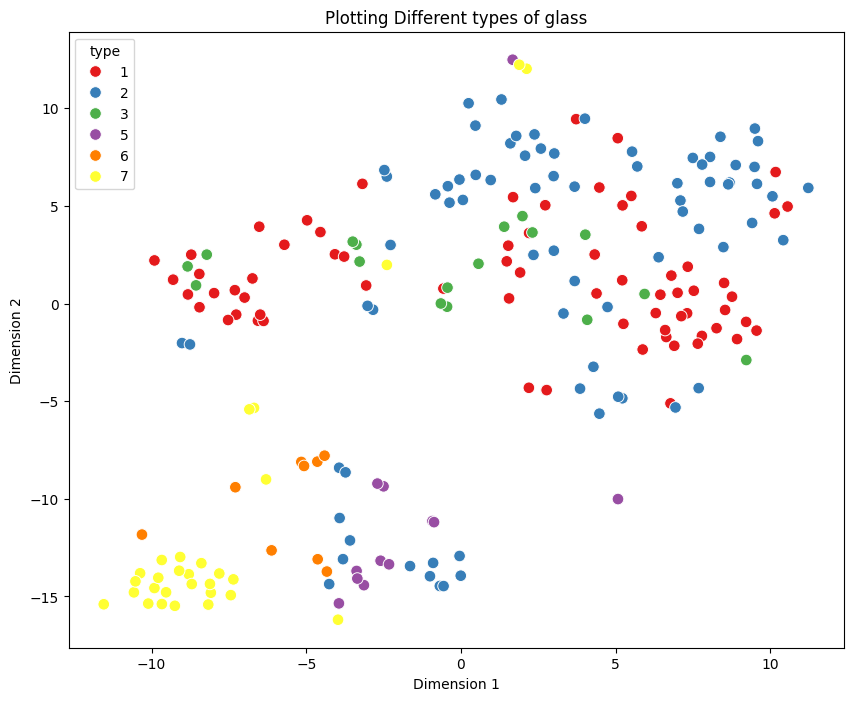

In [11]:
''' Uses t-distributed Stochastic Neighbour Embedding (t-SNE)
    to reduce the dimensions of the feature columns and allow us to
    plot it against the target variable column `type`
'''

tsne = TSNE(n_components = 2, random_state = 42)
reduced_features = tsne.fit_transform(features)
reduced_df = pd.DataFrame(reduced_features,
                          columns = ['Dimension 1', 'Dimension 2'])
reduced_df['type'] = target.values
plt.figure(figsize=(10, 8))

sns.scatterplot(x ='Dimension 1',
                y= 'Dimension 2',
                hue = 'type',             # color
                data = reduced_df,
                palette = 'Set1',
                s = 70)

# Set plot title and labels
plt.title('Plotting Different types of glass')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Show the plot
plt.show()

Glass type 3, 5, and 6 are an obvious minority class that might make the model biased in learning the majority class. Thus this class imbalance must be addressed in the preprocessing stage with `SMOTE`. [t-SNE](https://www.youtube.com/watch?v=o_cAOa5fMhE) was used to reduce the dimensions of all features into two so that we may plot it on a 2D Graph. In the most basic sense, we used it because it ensures that the distances of every point in the higher dimension stay similar when represented in a lower dimension space. Although it is much slower than Principal Component Analysis, it can capture the distances of these datapoints more accurately.

In [12]:
# Showing the skewness in each feature:
features.skew(skipna = False) # There are no null/NaN values anyway

RI    1.625431
Na    0.454181
Mg   -1.152559
Al    0.907290
Si   -0.730447
K     6.551648
Ca    2.047054
Ba    3.416425
Fe    1.754327
dtype: float64

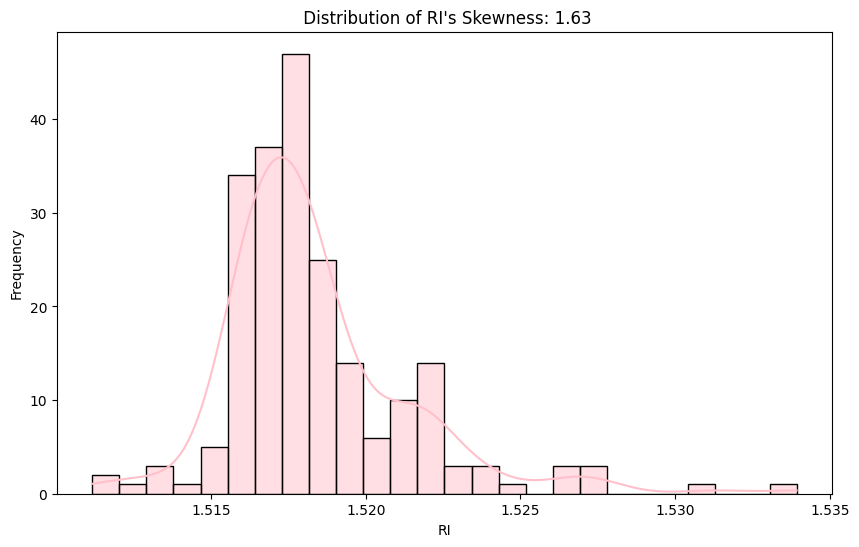

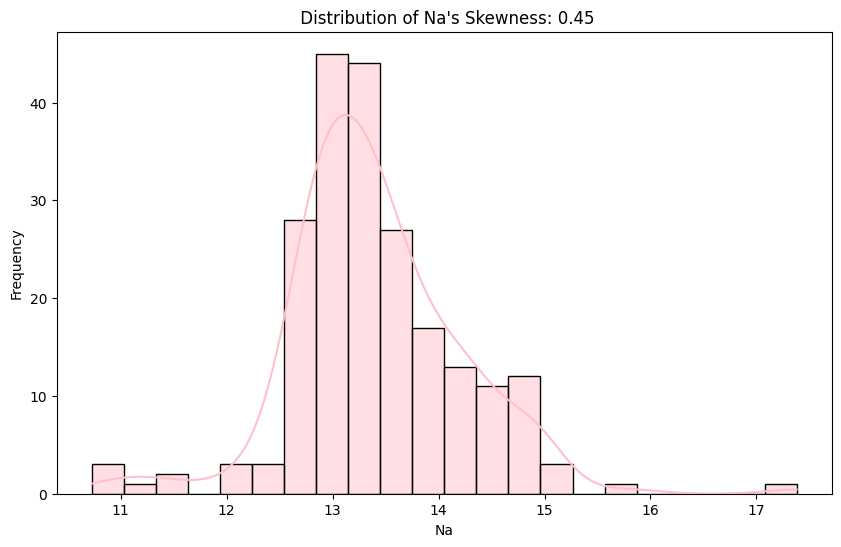

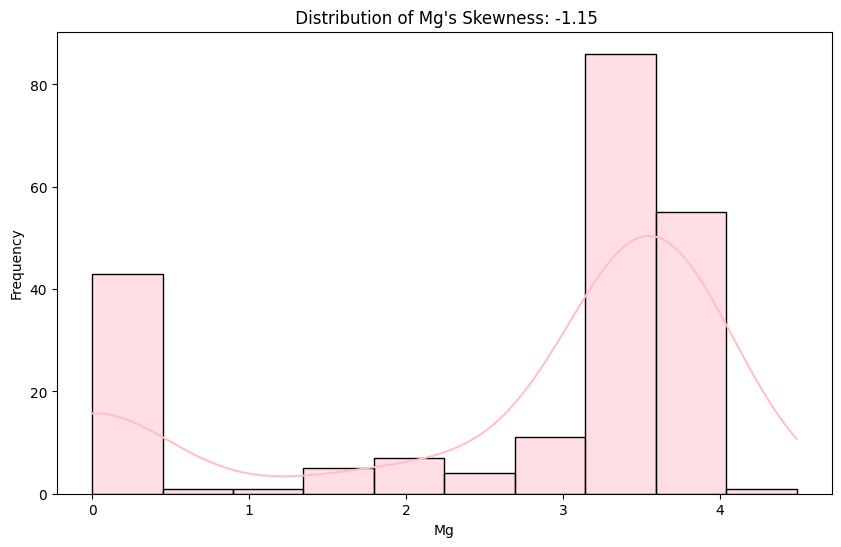

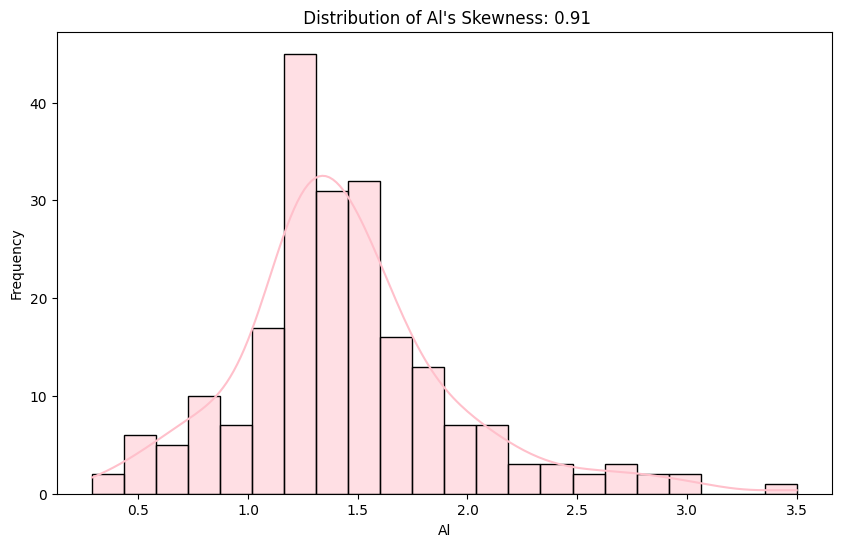

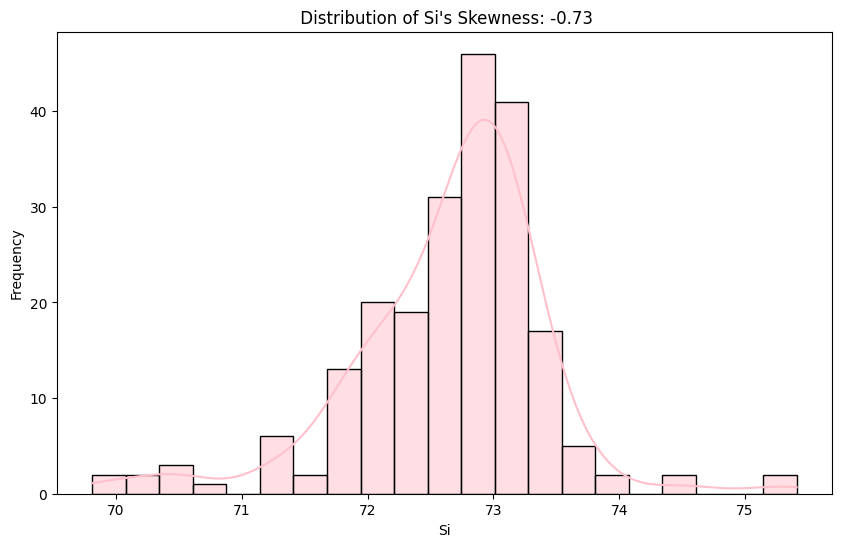

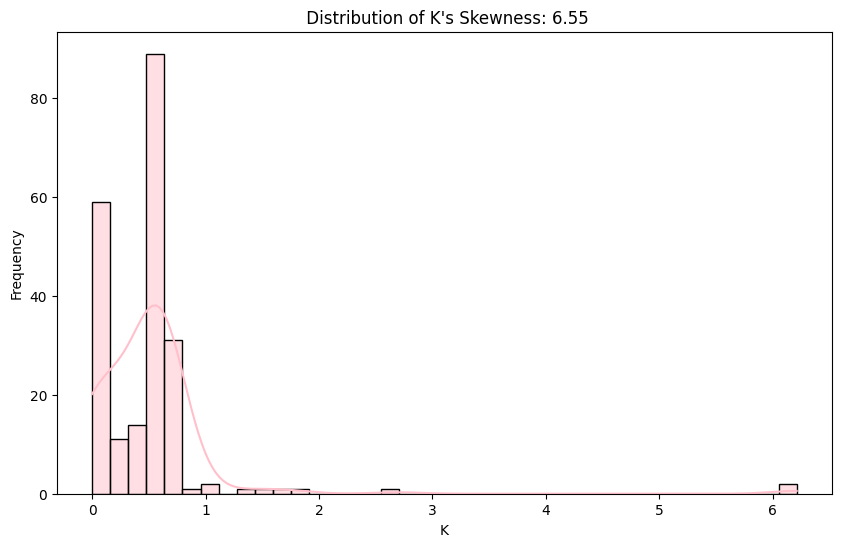

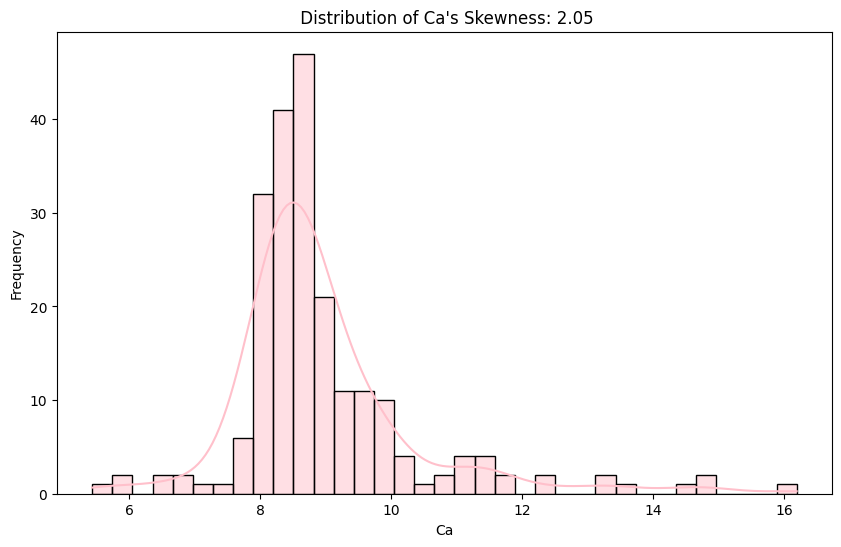

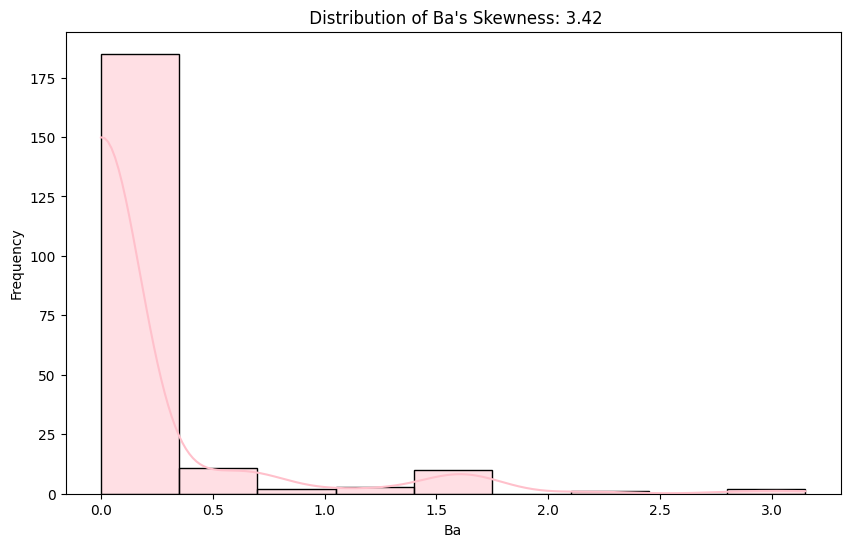

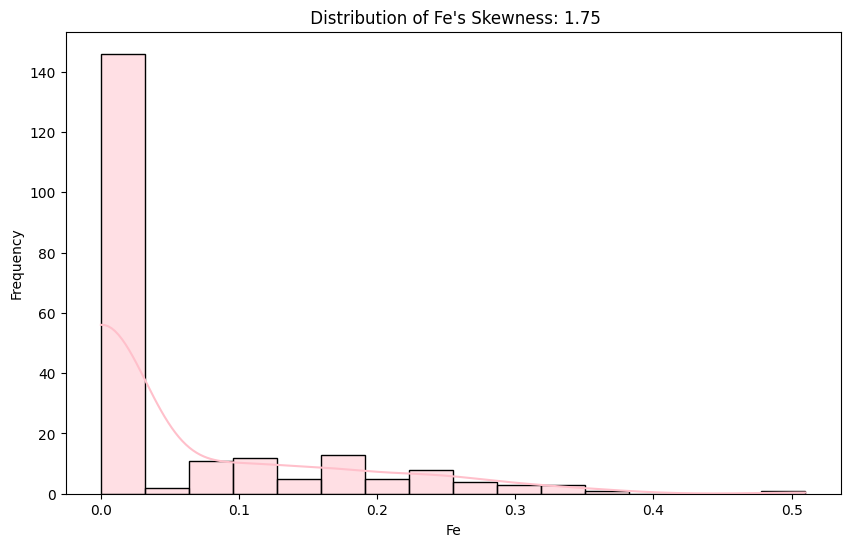

In [13]:
# Plotting the curve for every feature:

for column in features.select_dtypes(include = ['float64', 'int64']).columns:
  plt.figure(figsize = (10, 6))
  sns.histplot(features[column], kde = True, color = 'pink') # pink is better
  plt.title(f' Distribution of {column}\'s Skewness: ' +
   f'{features[column].skew():.2f}')
  plt.xlabel(column)
  plt.ylabel('Frequency')
  plt.show()

skewness = 0 : normally distributed.

skewness > 0 : positively skewed (tail on the right).

skewness < 0 : negatively skwewed (tail on the left).

There are a lot of data that are skewed to the right. Considering that the assigned model is Naive Bayes, we assume that the specific model to be used is GaussianNB, which assumes a Gaussian (normal) distribution of the features. Simply put, though it expects each feature to be dependent of each other, a probability distribution should be symmetric with respect to the mean. A gaussian distribution should have a skewness of 0. In order to address this, the presence of outliers must be investigated.Furthermore, mathematical data transformation may help in reducing the skewness and make the distribution more symmetric.

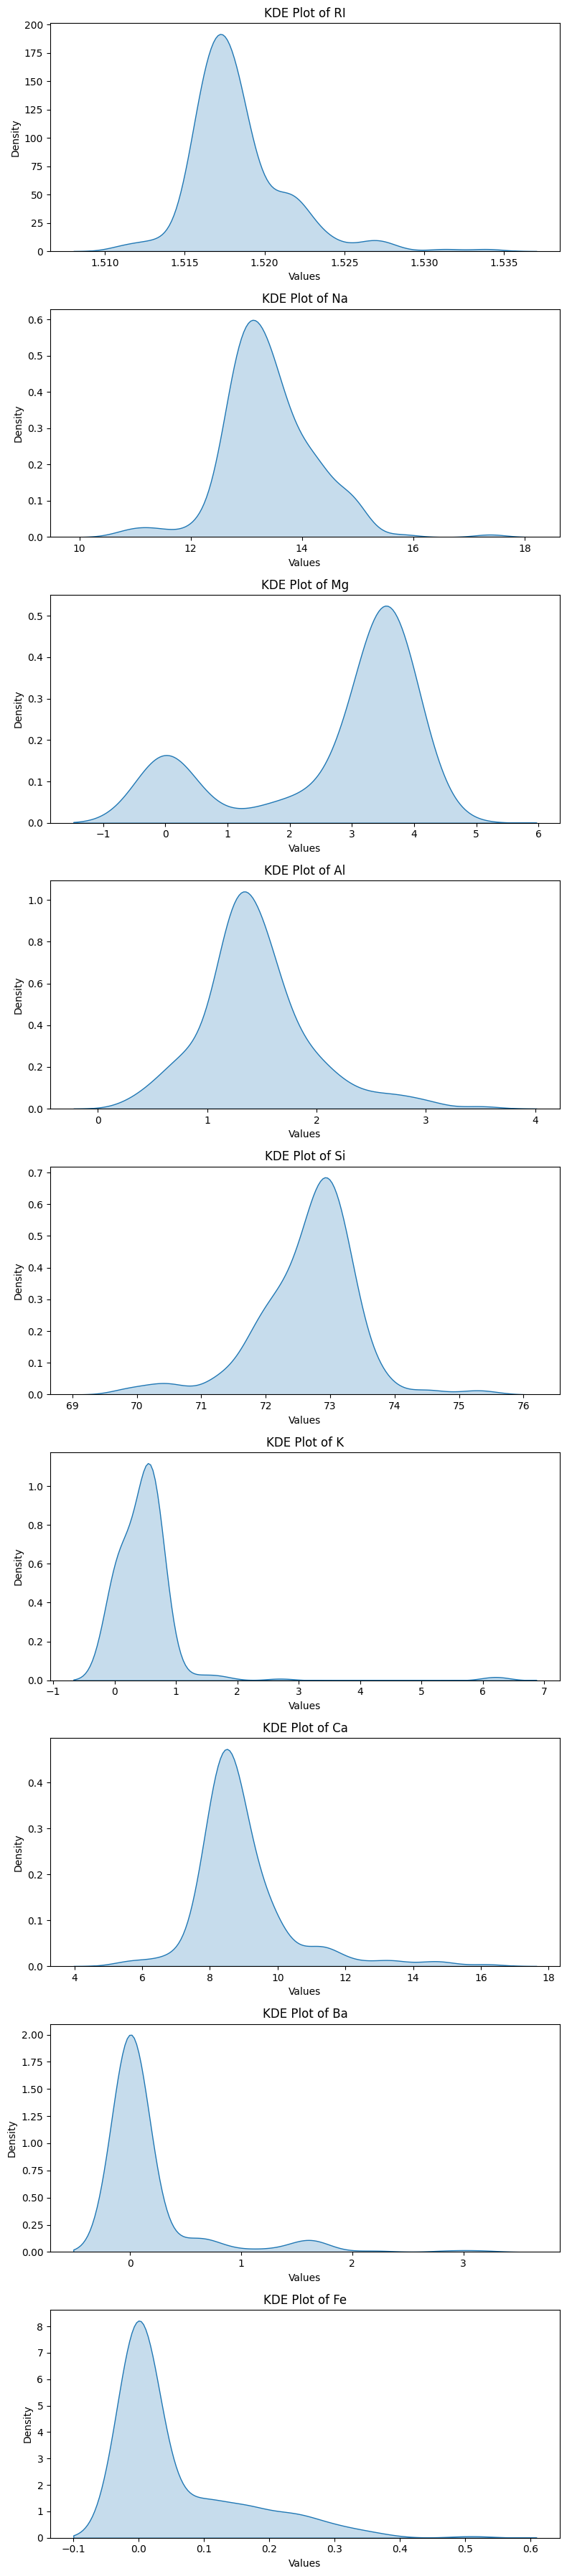

In [14]:
# KDE to visualize smoother distribution of data in each feature:

features_count = len(features.columns)
fig, axes = plt.subplots(nrows = features_count,
                         ncols = 1,
                         figsize = (8, 4 * features_count))

for i, feature in enumerate(features.columns):
    sns.kdeplot(features[feature], ax = axes[i], fill = True)
    axes[i].set_title(f'KDE Plot of {feature}')
    axes[i].set_xlabel('Values')
    axes[i].set_ylabel('Density')

plt.tight_layout()
plt.show()

To handle the skewness, transformation methods in the preprocessing such as yeo-johnson needs to be employed on skewed data.

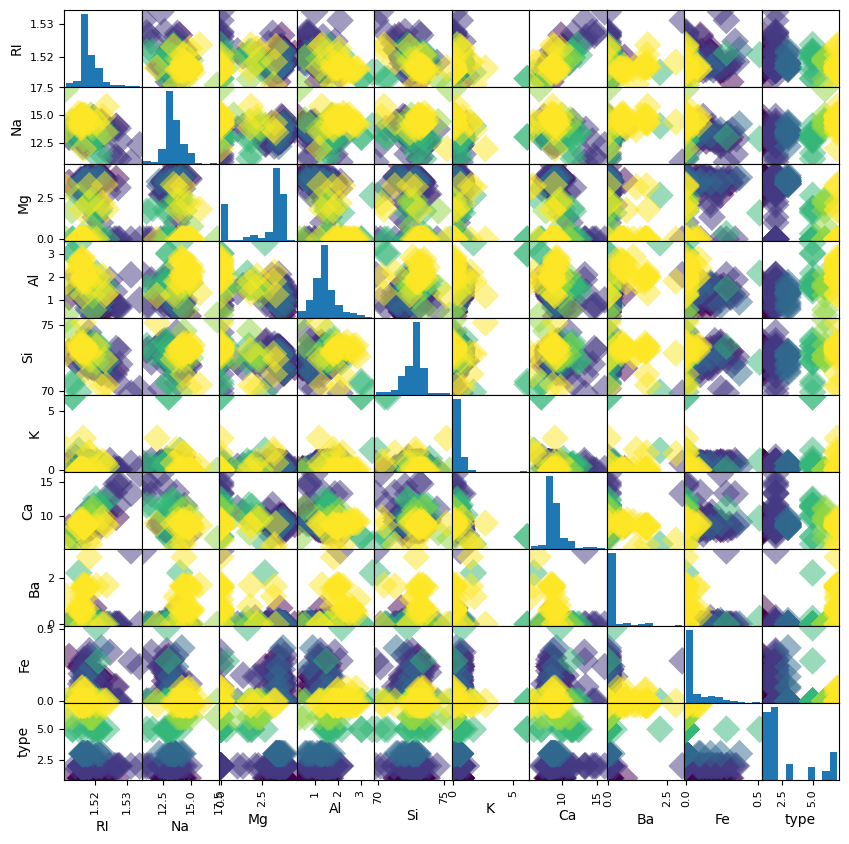

In [15]:
# Plotting scatter matrix to visualize data:
sc_matrix = pd.plotting.scatter_matrix(glass_df,
                                       c = glass_df['type'],
                                       figsize = [10, 10],
                                       s = 200,
                                       marker = 'D')

The scatterplots are colored based on the different classes of glass. Considering that there are 6 classes, there are also 6 unique colors (maroon, purple, deep blue, green, light green, and yellow). The pairwise relationship of each column are plotted against each other. However, focusing on the pairwise relationship/plotting of each feature against the type: Non-linear relationships are observed in the figures, where clusters are thereby the most discernible. The histograms on the diagonals show the distribution of each variable.

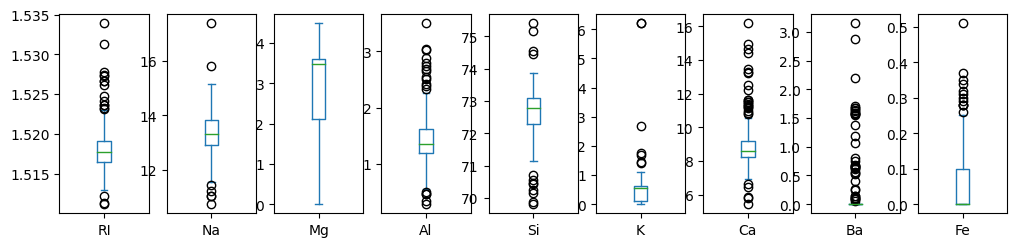

In [16]:
# Showing a box whisker plot:
features.plot(kind = 'box',
              subplots = True,
              layout = (5, 11),
              figsize = (15, 15),
              sharex  = False,
              sharey = False)

plt.show()

The Box-Whisker plot above shows the Q1 (25th percentile) as the lower end of the box while the Q3 closes the upper part of the box. The box then represents the Inter Quartile Range (IQR: Q3 - Q1). The green line within is Q2 or the median line for each feature. The low whisker represents the lower outlier (Q1 - (1.5 * IQR)). While the higher whisker represents the upper outlier (Q3 + (1.5 * IQR)). The plotted circles within each element/column represents the outliers as they are found past the threshold of the lower and upper outliers. The discovery of the outliers may affect the model for classifying, thus it must be removed from the dataset later on.

# 2. Data Preprocessing

In [17]:
# Checks for duplicates:

duplicates = glass_df[glass_df.duplicated()]
print(duplicates)
rows_38_to_41 = glass_df.iloc[37:41]
print("\nChecking for the duplicate b/n Rows 38 to 41:")
print(rows_38_to_41)

         RI     Na    Mg    Al     Si     K    Ca   Ba   Fe  type
39  1.52213  14.21  3.82  0.47  71.77  0.11  9.57  0.0  0.0     1

Checking for the duplicate b/n Rows 38 to 41:
         RI     Na    Mg    Al     Si     K    Ca   Ba   Fe  type
37  1.51797  12.74  3.48  1.35  72.96  0.64  8.68  0.0  0.0     1
38  1.52213  14.21  3.82  0.47  71.77  0.11  9.57  0.0  0.0     1
39  1.52213  14.21  3.82  0.47  71.77  0.11  9.57  0.0  0.0     1
40  1.51793  12.79  3.50  1.12  73.03  0.64  8.77  0.0  0.0     1


In [18]:
# Drops the duplicate at row 39 for features and target variable df:
glass_df.drop_duplicates(keep = 'first', inplace = True)
cleaned_features = glass_df.iloc[37:41]
print(f'glass df with removed duplicates:\n {cleaned_features}')

glass df with removed duplicates:
          RI     Na    Mg    Al     Si     K    Ca   Ba   Fe  type
37  1.51797  12.74  3.48  1.35  72.96  0.64  8.68  0.0  0.0     1
38  1.52213  14.21  3.82  0.47  71.77  0.11  9.57  0.0  0.0     1
40  1.51793  12.79  3.50  1.12  73.03  0.64  8.77  0.0  0.0     1
41  1.51755  12.71  3.42  1.20  73.20  0.59  8.64  0.0  0.0     1


In [19]:
glass_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 213 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      213 non-null    float64
 1   Na      213 non-null    float64
 2   Mg      213 non-null    float64
 3   Al      213 non-null    float64
 4   Si      213 non-null    float64
 5   K       213 non-null    float64
 6   Ca      213 non-null    float64
 7   Ba      213 non-null    float64
 8   Fe      213 non-null    float64
 9   type    213 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 18.3 KB


In [20]:
# Dropping the outliers via z-score

glass_df = glass_df[(np.abs(stats.zscore(glass_df)) < 3).all(axis=1)]

# Reassigning features and target
features = glass_df.drop(columns = ['type'])
target = glass_df['type']

''' Resets the indexing to ensure alignment, if we don't; then concatenating
    features and target column to re-form the dataframe would result in NaNs
    and indexing issues. The debugging process showed that the outliers were
    dropped for the `features` dataframe but not for the `target` dataframe.
    Resulting in mismatch when joining the two dataframes and produced the NaNs.
'''
features = features.reset_index(drop=True)
target = target.reset_index(drop=True)

print(f'Feature shape: {features.shape}\nTarget shape: {target.shape}')

Feature shape: (193, 9)
Target shape: (193,)


Outliers are calculated for every feature column and if the z-score is within 3 standard deviations from the mean, then values are kept. Otherwise, these 'outliers' are dropped. For context 3 standard deviations from the mean is encompasses 99.7% of the data in a distribution.

In [21]:
# Transformation of data to adjust skewness
transformer = PowerTransformer(method = 'yeo-johnson')
features = pd.DataFrame(transformer.fit_transform(features),
                        columns = features.columns)

In [22]:
# Showing the skewness in each feature after yeo-johnson:
features.skew(skipna = False) , # There are no null/NaN values anyway

(RI    0.000000
 Na   -0.018578
 Mg   -1.023486
 Al    0.010097
 Si    0.038827
 K     0.016426
 Ca   -0.084253
 Ba    1.963711
 Fe    0.852040
 dtype: float64,)

[Yeo-Johnson](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html#rf3e1504535de-2) is a power transformer that makes data more Gaussian like. The goal of reducing skewness is to make it more suitable for GaussianNB which assumes normally distributed data for each feature. Previously; Potassuim (K), Calcium (Ca), and Barium (Ba) were really skewed but transforming the data made it less asymmetrical and made the skew value closer to 0.

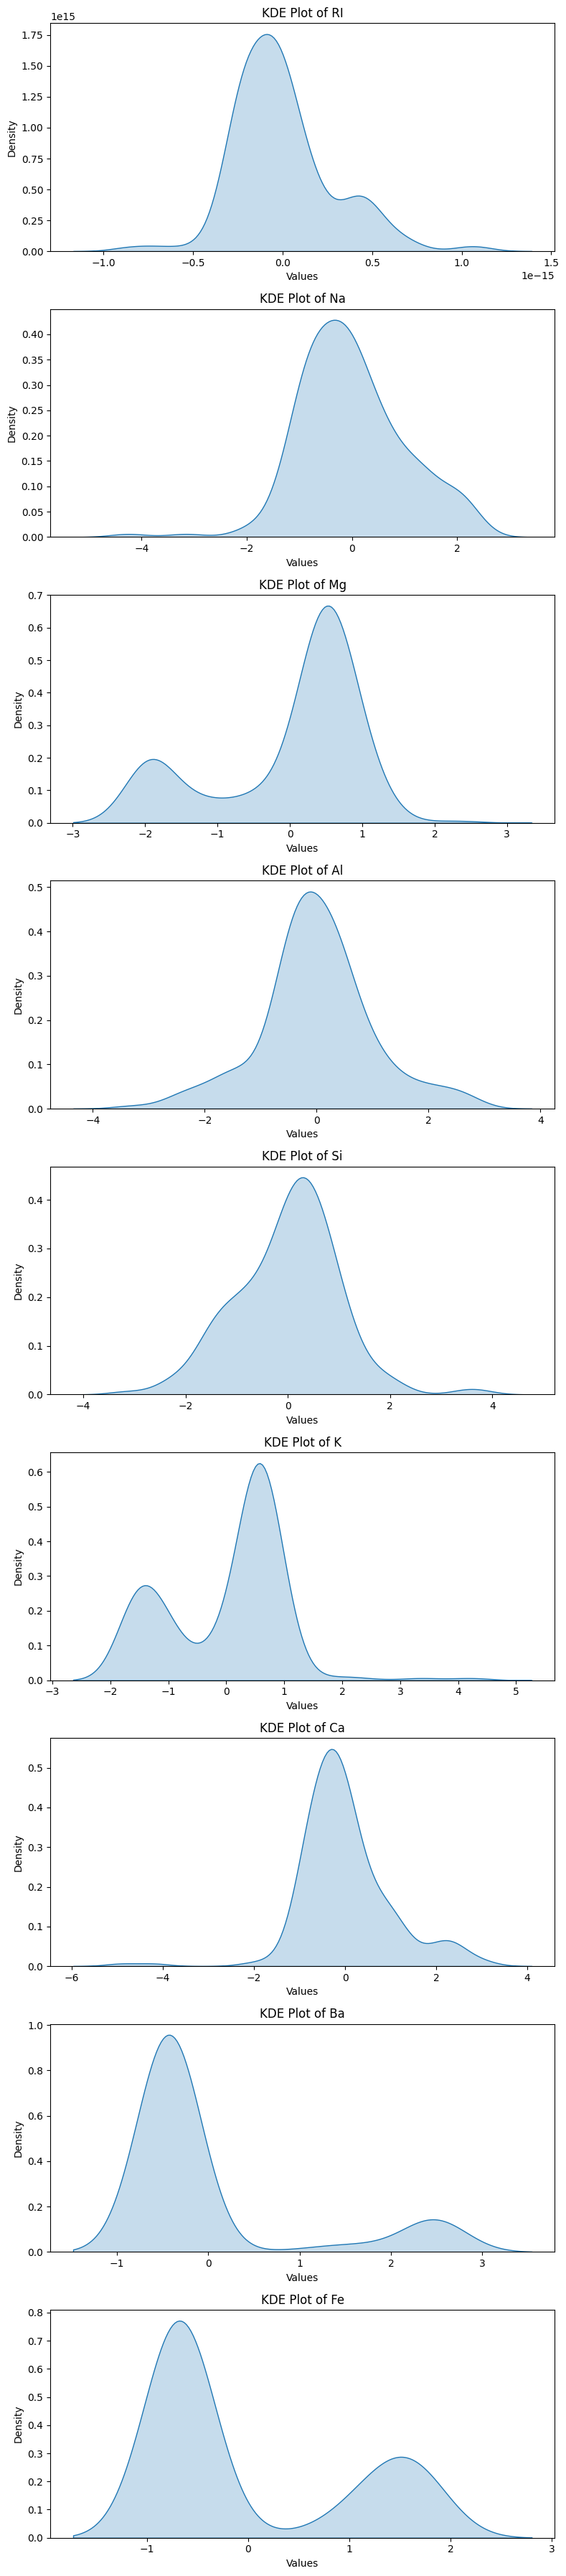

In [23]:
# Using KDE again to visualize distribution of each feature:

features_count = len(features.columns)
fig, axes = plt.subplots(nrows = features_count,
                         ncols = 1,
                         figsize = (8, 4 * features_count))

for i, feature in enumerate(features.columns):
    sns.kdeplot(features[feature], ax = axes[i], fill = True)
    axes[i].set_title(f'KDE Plot of {feature}')
    axes[i].set_xlabel('Values')
    axes[i].set_ylabel('Density')

plt.tight_layout()
plt.show()

The KDE plots visualizes how the transformed data has its skewness reduced.

# Model Building Scenarios:

**1) Test the performance of GaussianNB without the transformation and class balancing**

**2) Test the performance of GaussianNB with transformation and class balancing**

In [24]:
# Data for testing with transformation:
transformed_glass_df = pd.concat([features, target], axis = 1)
X_transformed = transformed_glass_df.drop(columns = ['type'])
y_transformed = transformed_glass_df['type']
print(f'Shape of dataset with transformation: {transformed_glass_df.shape}\n')

# Data for testing without transformation:
X_orig = glass_df.drop(columns = ['type'])
y_orig = glass_df['type']
print(f'Shape of dataset without transformation: {glass_df.shape}\n')

Shape of dataset with transformation: (193, 10)

Shape of dataset without transformation: (193, 10)



In [34]:
class NaiveClassifier:

  def __init__(self, X, y, method, apply_balancing = True):
    self.X = X
    self.y = y
    self.method = method
    self.apply_balancing = apply_balancing

  '''
    Applies the train test split on the dataset. If class balancing will be
    applied, uses SMOTEENN only on the trainset to avoid data leakage.
  '''
  def split(self):
    # Split the data for the NB model that utilizes all features (80/20)
    X_train, X_test, y_train, y_test = train_test_split(self.X, self.y,
                                                        test_size = 0.2,
                                                        random_state = 10)
    if (self.apply_balancing):
      print(f"Shape of unbalanced train set: {X_train.shape} & {y_train.shape}")
      X_train, y_train = SMOTEENN(sampling_strategy = 'not majority', random_state = 10).fit_resample(X_train, y_train)
      print(f"Class Balancing has been applied:\n" +
            f"Shape of balanced train set: {X_train.shape} & {y_train.shape}")

    return X_train, X_test, y_train, y_test

  '''
    Plots the train split, mainly used to showcase the classes of the train
    set. Also uses TSNE to plot the data in a 2-dimensional plane. The feature
    set is transformed using the standard scaler because of its sensitivity
    to the `scale` of bigger features
  '''
  def plot_train_split(self):
    X_train, X_test, y_train, y_test = self.split()
    print(f"Showing records of different classes:\n")
    df = pd.concat([X_train, y_train], axis = 1)
    sns.countplot(x = 'type', data = df)
    plt.show()

    tsne = TSNE(n_components = 2, random_state = 10)
    # Scaling X_train because of TSNE's sensitivity to the data's scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    rrf = tsne.fit_transform(X_train_scaled)
    rr_df = pd.DataFrame(rrf, columns = ['Dimension 1', 'Dimension 2'])
    rr_df['type'] = y_train.values
    plt.figure(figsize=(6, 4))

    sns.scatterplot(x ='Dimension 1',
                    y= 'Dimension 2',
                    hue = 'type',
                    data = rr_df,
                    palette = 'Set1',
                    s = 70)

    # Set plot title and labels
    plt.title('SMOTEENN Resampled Different Types of glass for trainset')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

    # Show the plot
    plt.show()

  '''
    Trains the Gaussian Naive Bayes model on the training data, applies
    Cross validation on 8 folds, and tests the model on test set. Returns
    the following metrics: accuracy, weighted precision, weighted recall,
    and the confusion matrix.
  '''
  def train_test(self):
    # Split the data for the NB model that utilizes all features (80/20)
    X_train, X_test, y_train, y_test = self.split()

    # Kfolds for cross validation with 8 splits
    kfold = KFold(n_splits = 8, shuffle = True, random_state = 10)

    # Initialize Gaussian Naive Bayes
    model = GaussianNB()

    # Cross validation using 8 folds
    print(f"Naive Bayes Model with {self.method}:\n")
    train_cv = cross_val_score(model, X_train, y_train,
                              cv = kfold, scoring = 'accuracy')

    # print CV accuracy and mean of every fold
    print(f'Accuracy for each fold (training): {train_cv}\n')
    print(f'Mean fold accuracy (training): {(train_cv.mean() * 100):.2f}%')

    # Training segment for the model
    model.fit(X_train, y_train)

    # Predictions on unseen data for validation
    y_pred = model.predict(X_test)

    # Print validation metrics of the model
    print(f'\nValidation Accuracy: {accuracy_score(y_test, y_pred):.2f}\n')

    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))

    precision = precision_score(y_test, y_pred, average = 'weighted')
    recall = recall_score(y_test, y_pred, average = 'weighted')

    print(f"\nPrecision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")

# 3. Model Building - No Transformation and No class balancing

**Gaussian Naive Bayes Model on all features:**

Showing records of different classes:



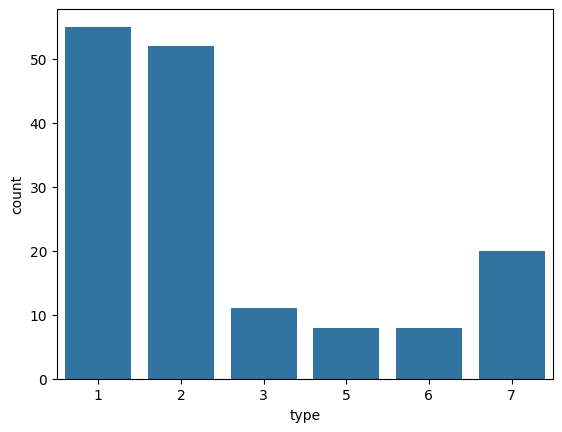

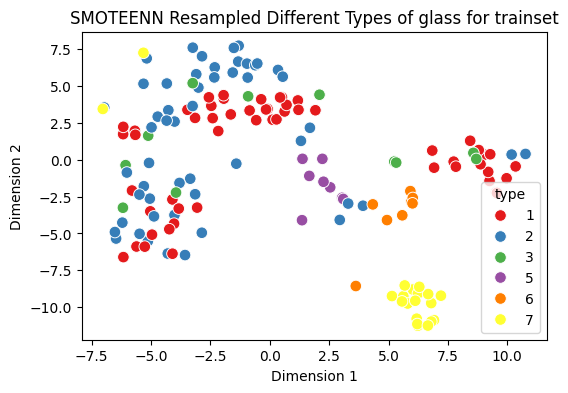

Naive Bayes Model with all features:

Accuracy for each fold (training): [0.45       0.4        0.36842105 0.15789474 0.26315789 0.31578947
 0.42105263 0.47368421]

Mean fold accuracy (training): 35.62%

Validation Accuracy: 0.23

Confusion Matrix:
[[ 0  3 11  0  0  0]
 [ 4  1  9  1  1  0]
 [ 1  0  4  0  0  0]
 [ 0  0  0  1  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  3]]

Precision: 0.21
Recall: 0.23


In [35]:
model_all_features = NaiveClassifier(X_orig, y_orig,
                                     method = "all features",
                                     apply_balancing = False)
# Plot is only showed once because it is the same given the random state
model_all_features.plot_train_split()
model_all_features.train_test()

**Gaussian Naive Bayes Model on Top 5 Features from Univariate Selection:**

In [38]:
# Gathering top 5 most pertinent features via Univariate Selection
# Chi-squared
bestfeatures = SelectKBest(score_func = chi2, k = 5)
fit = bestfeatures.fit(X_orig,y_orig)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_orig.columns)

feature_scores = pd.concat([dfcolumns, dfscores], axis = 1)
feature_scores.columns = ['Chemical comp.','Score']
print(f"Top 5 features using chi-squared:\n{feature_scores.nlargest(5, 'Score')}")

Top 5 features using chi-squared:
  Chemical comp.       Score
7             Ba  149.358188
2             Mg   83.678982
3             Al   14.062931
5              K    8.886232
6             Ca    8.106976


In [39]:
# Univariate Selection with f_classif
bestfeatures = SelectKBest(score_func = f_classif, k = 5)
fit = bestfeatures.fit(X_orig,y_orig)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_orig.columns)

feature_scores = pd.concat([dfcolumns, dfscores], axis = 1)
feature_scores.columns = ['Chemical comp.','Score']
print(f"Top 5 features using f_classif:\n{feature_scores.nlargest(5, 'Score')}")

Top 5 features using f_classif:
  Chemical comp.       Score
7             Ba  113.901158
2             Mg  101.008028
3             Al   44.115220
1             Na   34.293515
6             Ca   22.904161


In [43]:
# Split the data for the NB model that utilizes univariate selection features
X_orig_chi = glass_df[['Ba', 'Mg', 'Al', 'K', 'Na']]
model_univariate = NaiveClassifier(X_orig_chi, y_orig,
                                     method = "univariate selection",
                                     apply_balancing = False)
model_univariate.train_test()

Naive Bayes Model with univariate selection:

Accuracy for each fold (training): [0.4        0.35       0.42105263 0.15789474 0.26315789 0.36842105
 0.26315789 0.36842105]

Mean fold accuracy (training): 32.40%

Validation Accuracy: 0.21

Confusion Matrix:
[[ 0  1 13  0  0  0]
 [ 3  0 10  1  1  1]
 [ 1  0  4  0  0  0]
 [ 0  0  0  1  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  3]]

Precision: 0.09
Recall: 0.21


In [44]:
# f_classif results
X_orig_f = glass_df[['Ba', 'Mg', 'Al', 'Na', 'Ca']]
model_univariate = NaiveClassifier(X_orig_f, y_orig,
                                     method = "univariate selection",
                                     apply_balancing = False)
model_univariate.train_test()

Naive Bayes Model with univariate selection:

Accuracy for each fold (training): [0.4        0.4        0.42105263 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105]

Mean fold accuracy (training): 31.71%

Validation Accuracy: 0.21

Confusion Matrix:
[[ 0  1 13  0  0  0]
 [ 3  0 10  0  2  1]
 [ 1  0  4  0  0  0]
 [ 0  0  0  1  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  3]]

Precision: 0.10
Recall: 0.21


**Gaussian Naive Bayes Model on Top 5 Features from Feature Importance:**

[0.14027215 0.08812465 0.17680088 0.14593156 0.08655042 0.10723389
 0.12585914 0.0835806  0.0456467 ]


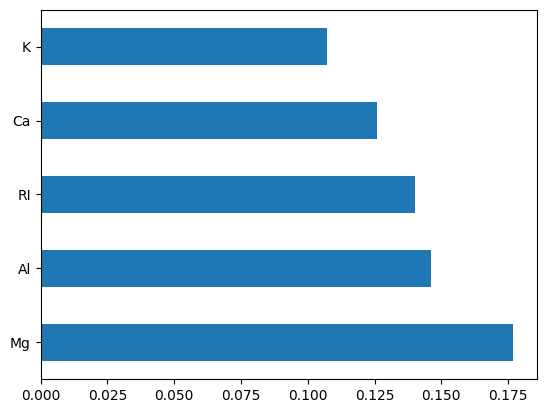

In [46]:
# Gathering top 5 most pertinent features via Feature Importance
etc_model = ExtraTreesClassifier()
etc_model.fit(X_orig, y_orig)
print(etc_model.feature_importances_)

feat_importances = pd.Series(etc_model.feature_importances_,
                             index = X_orig.columns)
feat_importances.nlargest(5).plot(kind = 'barh')
plt.show()

In [48]:
# Split the data for the NB model that utilizes feature importance
X_orig_fi = glass_df[['Mg', 'Al', 'RI', 'Ca', 'K']]
model_fi = NaiveClassifier(X_orig_fi, y_orig, method = "feature importance",
                           apply_balancing = False)
model_fi.train_test()

Naive Bayes Model with feature importance:

Accuracy for each fold (training): [0.4        0.7        0.52631579 0.63157895 0.52631579 0.73684211
 0.73684211 0.63157895]

Mean fold accuracy (training): 61.12%

Validation Accuracy: 0.56

Confusion Matrix:
[[ 8  6  0  0  0  0]
 [ 3 12  0  0  1  0]
 [ 5  0  0  0  0  0]
 [ 0  0  0  1  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  2  1]]

Precision: 0.56
Recall: 0.56


**Gaussian Naive Bayes Model on Top 5 Features from Correlation Coefficient:**

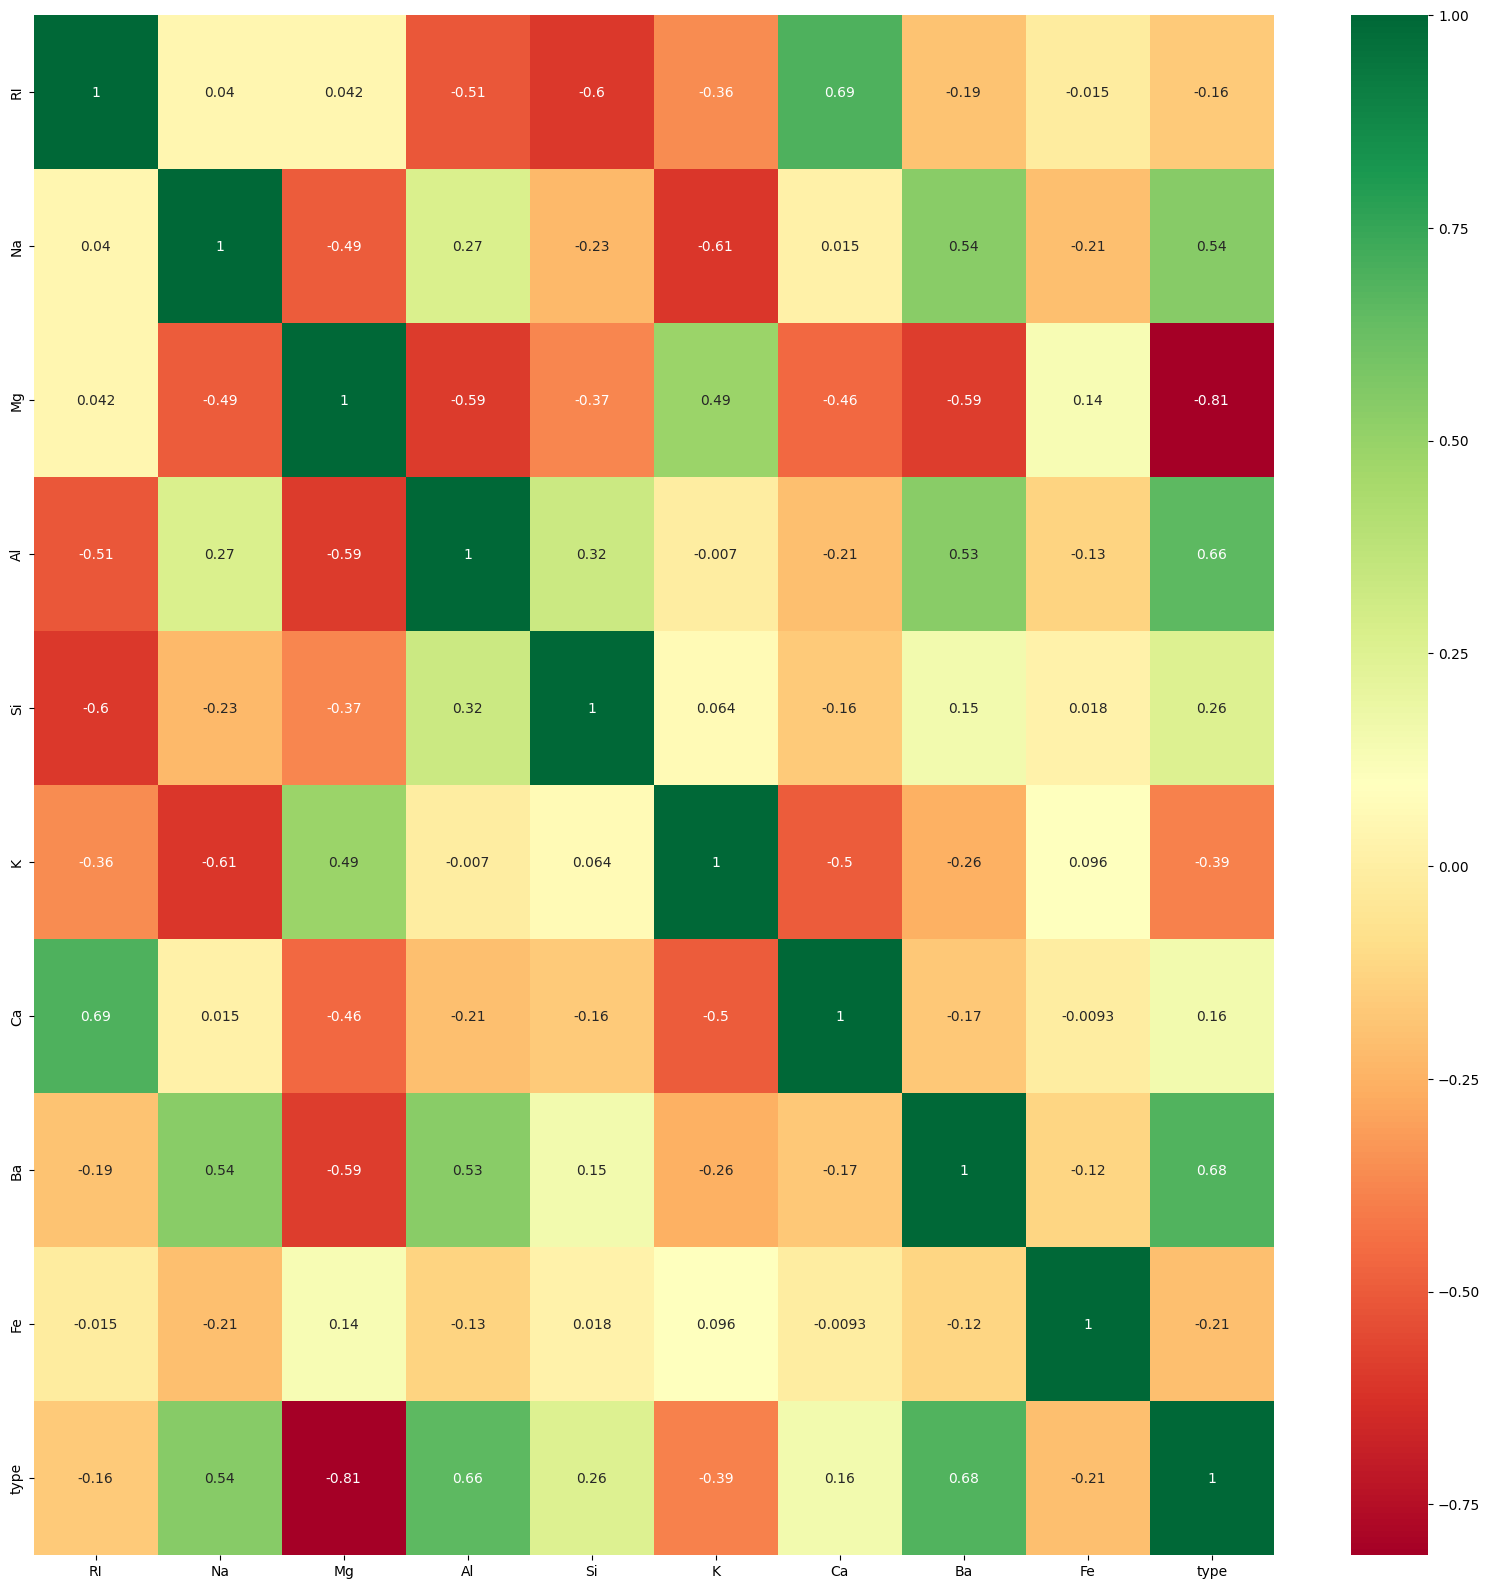

In [49]:
# Gathering top 5 most pertinent features via Correlation
corr_matrix = glass_df.corr()
top_corr_features = corr_matrix.index
plt.figure(figsize=(20,20))
g = sns.heatmap(glass_df[top_corr_features].corr(),
                annot = True,
                cmap = "RdYlGn")

Feature correlation arranged in descending order via 'type':
Ba    0.682676
Al    0.660404
Na    0.540764
Si    0.257606
Ca    0.158387
RI   -0.161575
Fe   -0.205058
K    -0.390192
Mg   -0.809767
Name: type, dtype: float64


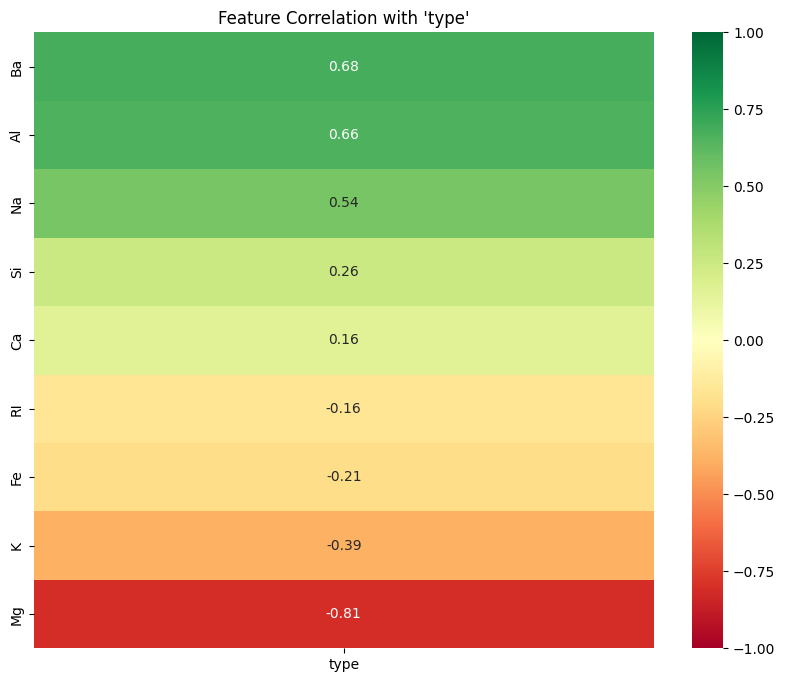

In [50]:
# Extract the correlation of each feature with the target variable 'price_range'
target_corr = corr_matrix['type'].drop('type')

corr_features = target_corr.sort_values(ascending = False)

print("Feature correlation arranged in descending order via 'type':")
print(corr_features)

plt.figure(figsize=(10, 8))
sns.heatmap(target_corr.sort_values(ascending=False).to_frame(),
            annot = True, cmap = "RdYlGn", vmin = -1, vmax = 1)
plt.title("Feature Correlation with 'type'")
plt.show()

In [51]:
# Split the data for the NB model that utilizes Correlation Coefficient
X_orig_corr = glass_df[['Ba', 'Al', 'Na', 'Si', 'Ca']]
model_corr = NaiveClassifier(X_orig_corr, y_orig,
                             method = "correlation coefficient",
                             apply_balancing = False)
model_corr.train_test()

Naive Bayes Model with correlation coefficient:

Accuracy for each fold (training): [0.4        0.3        0.42105263 0.15789474 0.21052632 0.26315789
 0.31578947 0.31578947]

Mean fold accuracy (training): 29.80%

Validation Accuracy: 0.21

Confusion Matrix:
[[ 0  0 14  0  0  0]
 [ 4  0 10  0  2  0]
 [ 1  0  4  0  0  0]
 [ 0  0  0  1  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  3]]

Precision: 0.12
Recall: 0.21


# 3. Model Building - With Transformation and class balancing

**Gaussian Naive Bayes Model on all features:**

Shape of unbalanced train set: (154, 9) & (154,)
Class Balancing has been applied:
Shape of balanced train set: (239, 9) & (239,)
Showing records of different classes:



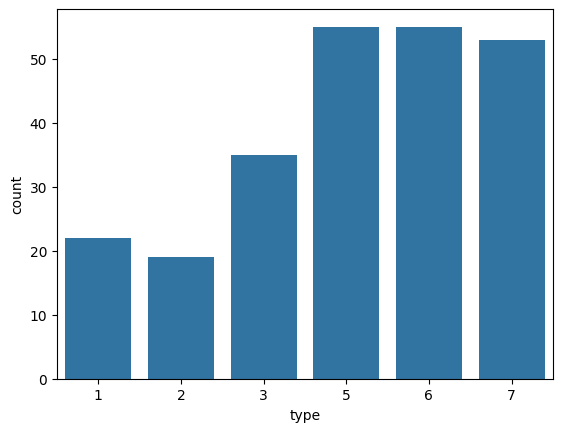

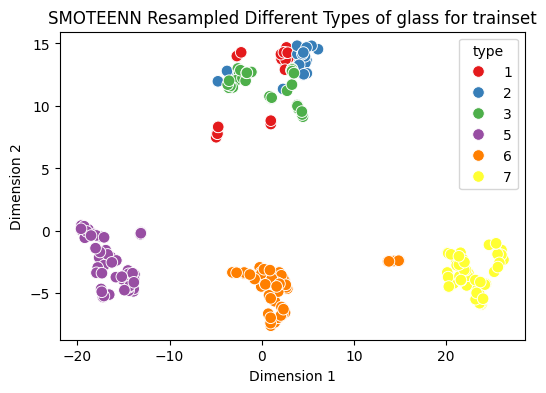

Shape of unbalanced train set: (154, 9) & (154,)
Class Balancing has been applied:
Shape of balanced train set: (239, 9) & (239,)
Naive Bayes Model with all features:

Accuracy for each fold (training): [1.         0.86666667 0.93333333 1.         0.83333333 0.93333333
 0.96666667 0.89655172]

Mean fold accuracy (training): 92.87%

Validation Accuracy: 0.44

Confusion Matrix:
[[2 7 5 0 0 0]
 [4 8 2 1 1 0]
 [1 0 4 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [1 0 0 0 0 2]]

Precision: 0.44
Recall: 0.44


In [52]:
''' Run the naive bayes model on the transformed data set with class balancing.
    Feature selection utilizes all features.
'''
model_all_features2 = NaiveClassifier(X_transformed, y_transformed,
                                     method = "all features",
                                     apply_balancing = True)
# Plot is only showed once because it is the same given the random state
model_all_features2.plot_train_split()
model_all_features2.train_test()

By doing SMOTE, we are able to synthetically sample the minority classes to match the majority classes, essentially solving the class imbalance problem. Given a minority class, SMOTE generates samples through interpolation via nearest neighbours. Assume a data point, it basically picks a random neighbour and generates a new datapoint between them. However this can be subject to noise and thus [SMOTEENN](https://imbalanced-learn.org/stable/combine.html#combine) is used because it cleans the data and resolves the noisy data generation by previous SMOTE implementations.

**Gaussian Naive Bayes Model using univariate selection:**

In [53]:
'''
  Gathering top 5 most pertinent features via Univariate Selection.
  Note that chi-squared cannot be applied on class balancing because
  SMOTE-ENN produces negative integers as synthetic data
'''
bestfeatures = SelectKBest(score_func = f_classif, k = 5)
fit = bestfeatures.fit(X_transformed, y_transformed)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_transformed.columns)

feature_scores = pd.concat([dfcolumns, dfscores], axis = 1)
feature_scores.columns = ['Chemical comp.','Score']
print(f"Top 5 features using f_classif: {feature_scores.nlargest(5, 'Score')}")

Top 5 features using f_classif:   Chemical comp.       Score
7             Ba  113.462494
2             Mg   86.033899
3             Al   34.335837
1             Na   31.112894
6             Ca   17.009616


In [54]:
''' Run the naive bayes model on the transformed data set with class balancing.
    Feature selection utilizes Univariate Selection with f_classif.
'''
X_transformed_f = transformed_glass_df[['Ba', 'Mg', 'Al', 'Na', 'Ca']]
model_uni2 = NaiveClassifier(X_transformed_f, y_transformed,
                                     method = "univariate selection",
                                     apply_balancing = True)

model_uni2.train_test()

Shape of unbalanced train set: (154, 5) & (154,)
Class Balancing has been applied:
Shape of balanced train set: (242, 5) & (242,)
Naive Bayes Model with univariate selection:

Accuracy for each fold (training): [1.         0.96774194 1.         0.96666667 1.         1.
 1.         0.96666667]

Mean fold accuracy (training): 98.76%

Validation Accuracy: 0.54

Confusion Matrix:
[[6 5 3 0 0 0]
 [2 8 0 0 2 4]
 [1 0 3 0 0 1]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 3]]

Precision: 0.61
Recall: 0.54


In [57]:
# Instead, we handpick the top 5 features of chi-squared from the previous run
X_transformed_chi = transformed_glass_df[['Ba', 'Mg', 'Al', 'K', 'Ca']]
model_uni3 = NaiveClassifier(X_transformed_chi, y_transformed,
                                     method = "univariate selection",
                                     apply_balancing = True)
model_uni3.train_test()

Shape of unbalanced train set: (154, 5) & (154,)
Class Balancing has been applied:
Shape of balanced train set: (250, 5) & (250,)
Naive Bayes Model with univariate selection:

Accuracy for each fold (training): [0.96875    0.8125     0.90322581 1.         0.93548387 0.90322581
 0.93548387 0.90322581]

Mean fold accuracy (training): 92.02%

Validation Accuracy: 0.49

Confusion Matrix:
[[4 5 5 0 0 0]
 [1 7 2 1 1 4]
 [0 0 4 0 0 1]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 3]]

Precision: 0.61
Recall: 0.49


**Gaussian Naive Bayes Model using feature importance:**

[0.         0.10945517 0.16998735 0.16727826 0.10499671 0.13047196
 0.15757285 0.10935919 0.05087852]


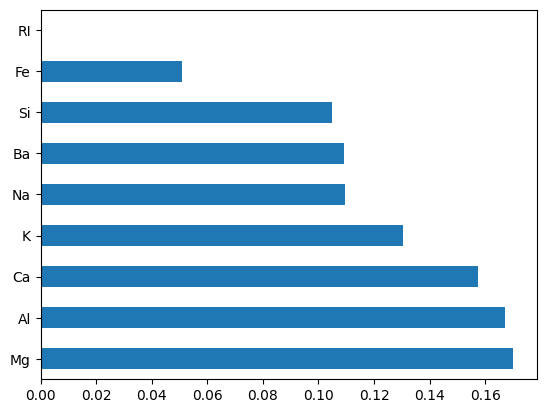

In [58]:
# Gathering top 5 most pertinent features via Feature Importance
etc_model = ExtraTreesClassifier()
etc_model.fit(X_transformed, y_transformed)
print(etc_model.feature_importances_)

feat_importances = pd.Series(etc_model.feature_importances_,
                             index = X_transformed.columns)
feat_importances.nlargest(10).plot(kind = 'barh')
plt.show()

In [59]:
''' Run the naive bayes model on the transformed data set with class balancing.
    Feature selection utilizes Feature Importance.
'''
X_transformed_fi = transformed_glass_df[['Mg', 'Al', 'Ca', 'K', 'Na']]
model_fi2 = NaiveClassifier(X_transformed_fi, y_transformed,
                            method = "feature importance",
                            apply_balancing = True)
model_fi2.train_test()

Shape of unbalanced train set: (154, 5) & (154,)
Class Balancing has been applied:
Shape of balanced train set: (248, 5) & (248,)
Naive Bayes Model with feature importance:

Accuracy for each fold (training): [0.77419355 0.87096774 0.87096774 0.93548387 0.77419355 0.93548387
 0.87096774 0.77419355]

Mean fold accuracy (training): 85.08%

Validation Accuracy: 0.56

Confusion Matrix:
[[ 6  4  4  0  0  0]
 [ 2 10  1  2  1  0]
 [ 1  0  4  0  0  0]
 [ 0  0  0  1  0  0]
 [ 0  0  0  0  0  0]
 [ 1  0  0  0  1  1]]

Precision: 0.65
Recall: 0.56


**Gaussian Naive Bayes Model using correlation:**

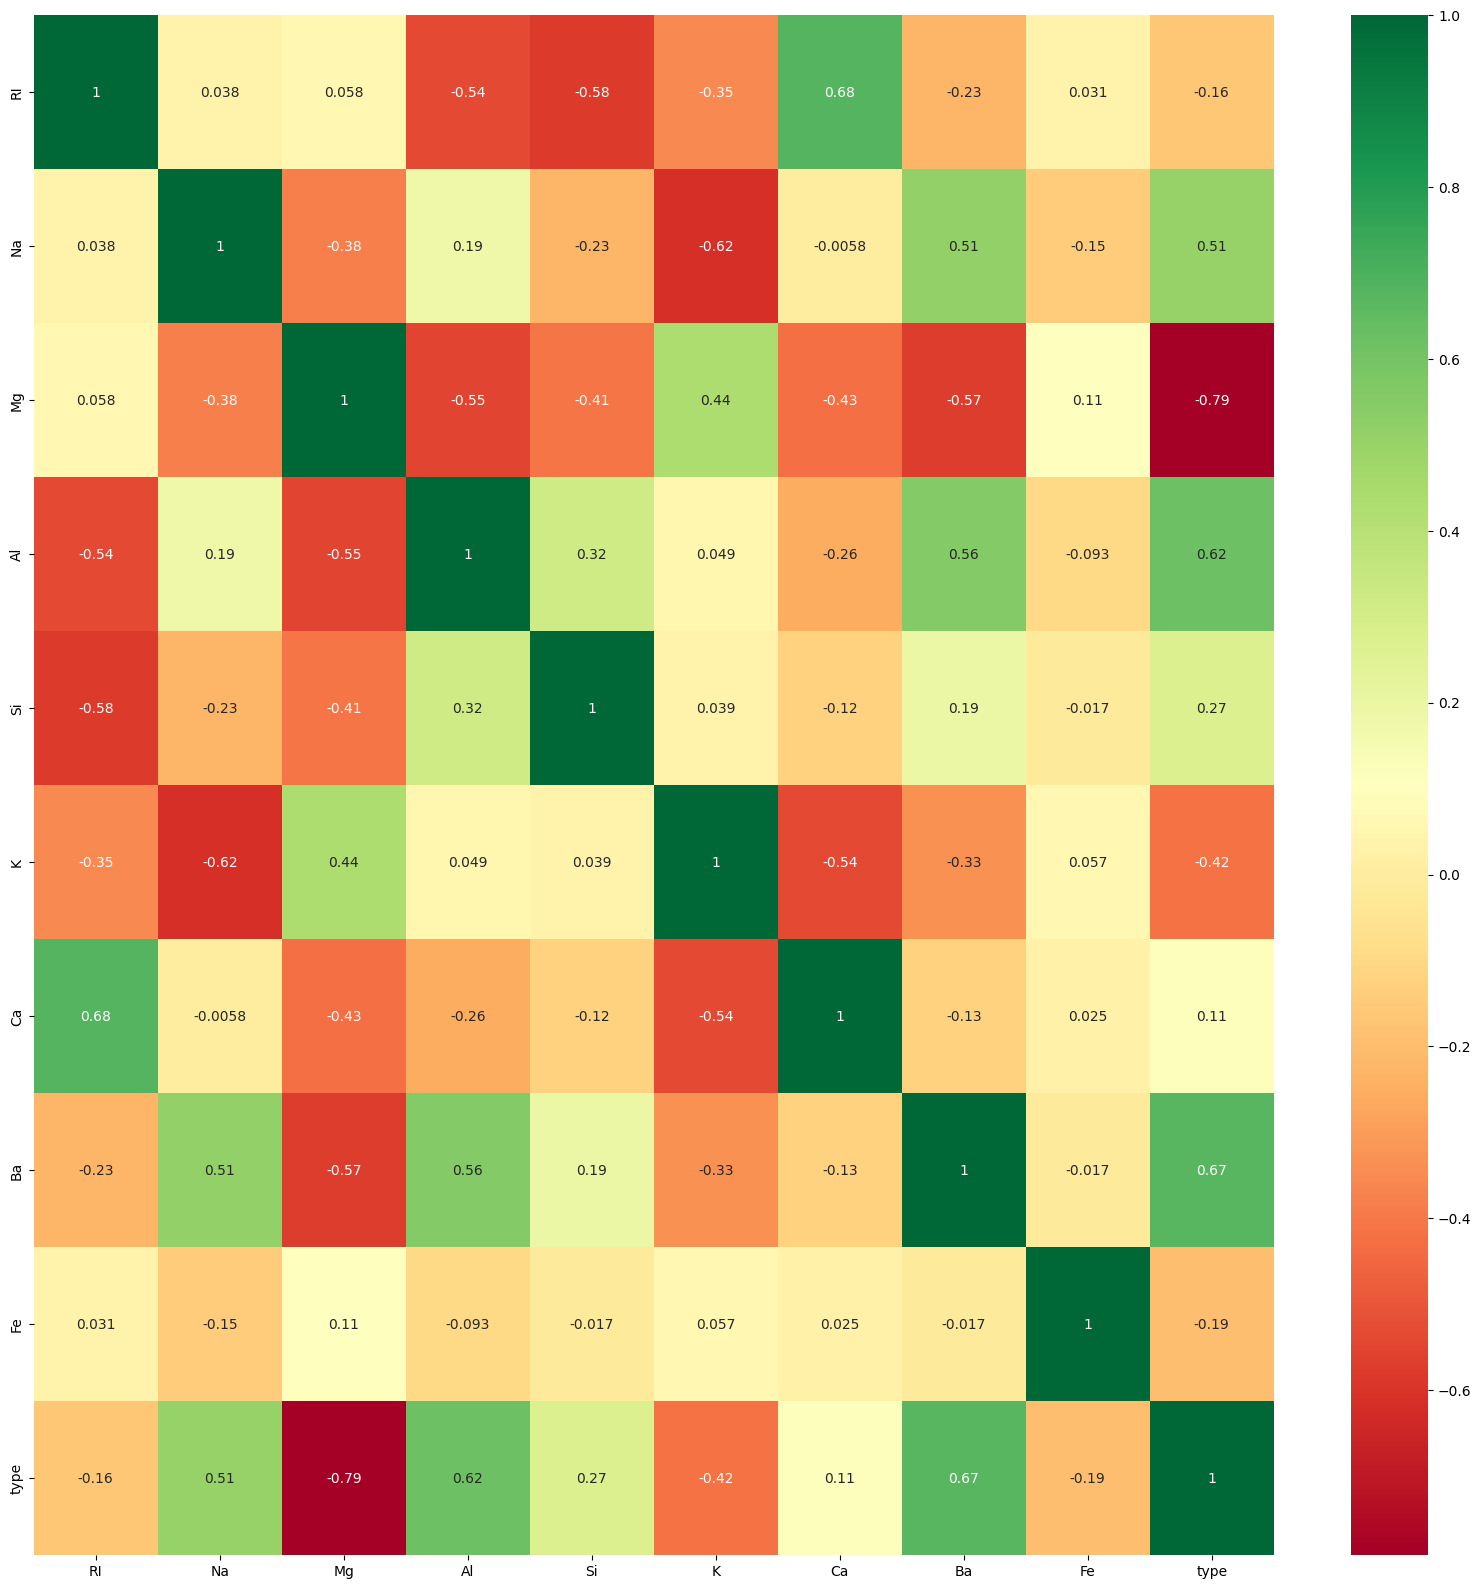

In [60]:
corr_matrix = transformed_glass_df.corr()
top_corr_features = corr_matrix.index
plt.figure(figsize=(20,20))
g = sns.heatmap(transformed_glass_df[top_corr_features].corr(),
                annot = True,
                cmap = "RdYlGn")

Feature correlation arranged in descending order via 'type':
Ba    0.674367
Al    0.616985
Na    0.508110
Si    0.267154
Ca    0.113385
RI   -0.164742
Fe   -0.191663
K    -0.416301
Mg   -0.792061
Name: type, dtype: float64


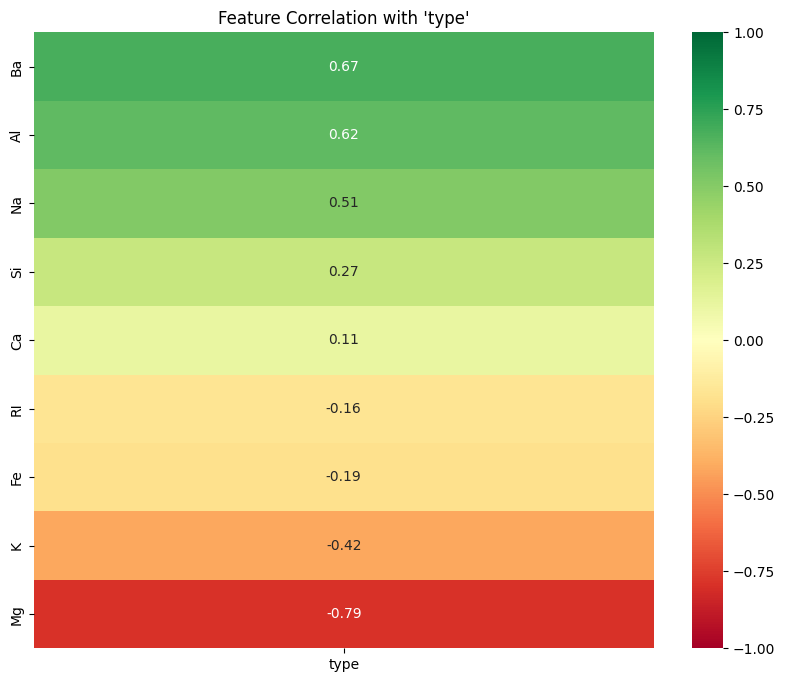

In [61]:
# Extract the correlation of each feature with the target variable 'price_range'
target_corr = corr_matrix['type'].drop('type')

corr_features = target_corr.sort_values(ascending = False)

print("Feature correlation arranged in descending order via 'type':")
print(corr_features)

plt.figure(figsize=(10, 8))
sns.heatmap(target_corr.sort_values(ascending = False).to_frame(),
            annot = True, cmap = "RdYlGn", vmin = -1, vmax = 1)
plt.title("Feature Correlation with 'type'")
plt.show()

In [62]:
''' Run the naive bayes model on the transformed data set with class balancing.
    Feature selection utilizes correlation.
'''
X_transformed_corr = transformed_glass_df[['Ba', 'Al', 'Na', 'Si', 'Ca']]
model_corr2 = NaiveClassifier(X_transformed_corr, y_transformed,
                              method = "correlation",
                              apply_balancing = True)
model_corr2.train_test()

Shape of unbalanced train set: (154, 5) & (154,)
Class Balancing has been applied:
Shape of balanced train set: (243, 5) & (243,)
Naive Bayes Model with correlation:

Accuracy for each fold (training): [0.90322581 0.87096774 0.96774194 1.         0.83333333 0.9
 0.93333333 0.9       ]

Mean fold accuracy (training): 91.36%

Validation Accuracy: 0.49

Confusion Matrix:
[[4 4 6 0 0 0]
 [1 7 2 0 2 4]
 [0 0 4 0 0 1]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 3]]

Precision: 0.65
Recall: 0.49
